<a href="https://colab.research.google.com/github/ThamirisNeves/Mestrado_EEG/blob/main/Traducao_matlab_python_Mistura_nao_linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tentativa de escrita do código A-SOBIPNL em python de uma maneira mais concisa


## Gerador dos sinais, sinais correlacionados entre si e a mistura (u(n), s(n) e x(n))

In [ ]:
from random import random
import numpy as np
import random as rd
from scipy.signal import lfilter
import matplotlib.pyplot as plt
from scipy import linalg

#Processo de Geracao dos sinais
## Set Parameters ========================================== ##

np.random.seed(0)

# Number of Samples:
n_samples = 1000

# Temporal Correlation Filters:
#temporal_cor1 = [1, 0.6, -0.2, 0.1]
temporal_cor1 = [1, 0.6, -0.2, 0.4]
temporal_cor2 = [1, -0.4, -0.3, 0.2]

#print('Temporal 1: ',temporal_cor1, '\n')
#print('Temporal 2: ',temporal_cor2, '\n')

# Mixing Matrix:
A = np.matrix('0.65 0.23; 0.35 0.76')
#A = np.matrix('0.8, -0.2; 0.4, 0.7')
print('Matriz de mistura: \n', A, '\n')

## ========================================================= ##


## Source Generation ======================================= ##

# Gaussian Source:
u1 = np.random.normal(0, 1, n_samples)
#print('u1:',u1)

# Uniform Source:
u2 = np.random.normal(0, 1, n_samples)
#u2 = np.random.uniform(-1, 1, n_samples)
#print('u2:',u2)

# Add Temporal Correlation:
s1 = lfilter(temporal_cor1, 1, u1)
s11 = [2*i/(np.max(abs(s1))) for i in s1]
#s11 = [i/(np.max(abs(s1))*2) for i in s1]
#s11 = [i/(np.max(abs(s1))**2) for i in s1]

s2 = lfilter(temporal_cor2, 1, u2)
s22 = [2*i/(np.max(abs(s2))) for i in s2]
#s22 = [i/(np.max(abs(s2))*2) for i in s2]
#s22 = [i/(np.max(abs(s2))**2) for i in s2]

#print('s1:',s1)
#print('s2:',s2)

# Combine Sources into a Single Variable:
S = np.c_[s11, s22]
print('S:', S)

#Matriz de Correlação dos sinais da fonte
R = np.cov(S.T, rowvar=True, bias=True)
print('Matriz de correlação dos sinais da fonte: \n',R, '\n')

# Add noise
#S += 0.2 * np.random.normal(size=S.shape)
# Standardize data
#S /= S.std(axis=0)

## ========================================================= ##

## Mixing Process ========================================== ##

#Mistura
# Generate Observations:
#X são os dados observados
X = np.dot(A,S.T)
print('X:',X)
print('X.shape:',X.shape)
X_T = X.T
print(X_T.shape)
print('Média: ',np.mean(X))

Matriz de mistura: 
 [[0.65 0.23]
 [0.35 0.76]] 

S: [[ 0.88208589  0.33525185]
 [ 0.72934368  0.40407121]
 [ 0.43304024 -0.570505  ]
 ...
 [ 0.00411378 -0.23634136]
 [-0.44316373 -0.96854599]
 [-0.57247809 -0.37473257]]
Matriz de correlação dos sinais da fonte: 
 [[ 0.38343055 -0.00991894]
 [-0.00991894  0.45329513]] 

X: [[ 0.65046375  0.56700977  0.15026    ... -0.05168456 -0.510822
  -0.45829925]
 [ 0.56352147  0.56236441 -0.28201972 ... -0.17817961 -0.89120226
  -0.48516408]]
X.shape: (2, 1000)
(1000, 2)
Média:  -0.018454239361871305


## Função parametrizada em tau para o AMUSE

O AMUSE retorna a matriz de separação, o X resultante da multiplicação do x branqueado e a matriz de separação, os dados branqueados, a matriz J que é a multiplicação de W*V (matriz de separação * matriz de branqueamento), e a matriz de covariância dos branqueados com atraso tau.

In [ ]:
def AMUSE(X, tau):
  #----------------Whitening data----------------------------------#
  X_T = X.T
  XC = X_T - np.mean(X_T, axis=0)

  XC = XC.T
  #XC = X_T.T

  # Calculate Covariance matrix
  # Note: 'rowvar=True' because each row is considered as a feature
  # Note: 'bias=True' to divide the sum of squared variances by 'n' instead of 'n-1'
  xcov = np.cov(XC, rowvar=True, bias=True)

  # Calculate Eigenvalues and Eigenvectors
  w, e = linalg.eig(xcov) # .eigh()

  # Calculate inverse square root of Eigenvalues
  # Optional: Add '.1e5' to avoid division errors if needed
  # Create a diagonal matrix
  diagw = np.diag(w) # or np.diag(1/((w+.1e-5)**0.5))
  diagw = diagw.real #convert to real and round off

  #Calculate whitening
  V = np.dot(e,np.dot(np.diag(1/(w.real**0.5)),e.T))

  Xwhite = np.dot(V,XC)

  #--------------------------------------------------------------#

  #TIME LAG -----------------------------------------------------#
  #matriz branqueada com valores sem lag ajustadas para o mesmo tamanho da matriz com lag
  X_nolag = Xwhite[:,tau:]
  #matriz branqueada com valores com lag ajustadas para o mesmo tamanho da matriz com lag

  X_lag = Xwhite[:,:-tau] if tau != 0 else Xwhite[:,:]

  #Matriz de Covariância da
  C_z_tau = (1/(Xwhite.shape[1] - tau))*(np.dot(X_nolag,X_lag.T) + (np.dot(X_lag,X_nolag.T)))

  #Autovalores e autovetores da matriz de coveriância usando time lag
  w1, e1 = linalg.eig(C_z_tau) # .eigh()

  #As linhas da matriz de separação W são dadas pelos autovetores
  W = e1.T

  #X_RES é o X resultante da multiplicação do x branqueado e a matriz de separação
  X_RES = np.dot(W,Xwhite)

  J = np.matmul(W,V) #????

  return  W, X_RES, Xwhite, J, C_z_tau

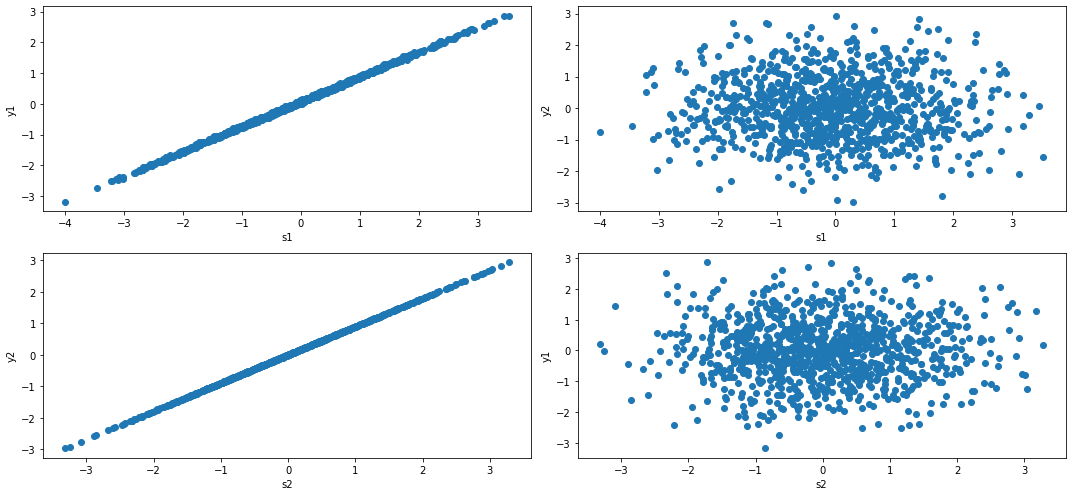

In [ ]:
#melhores atrasos: 1, 7, 11, 15, 16
W_matriz, y, X_white, J, cov = AMUSE(X,1)

#plot da recuperação dos sinais

y1 = y[0,:].reshape(-1).tolist()
y2 = y[1,:].reshape(-1).tolist()

fig,ax = plt.subplots(2,2,figsize=(15,7))

ax[0][0].scatter(s1,y1)
ax[0][0].set_xlabel('s1')
ax[0][0].set_ylabel('y1')

ax[1][0].scatter(s2,y2)
ax[1][0].set_xlabel('s2')
ax[1][0].set_ylabel('y2')

ax[1][1].scatter(s2,y1)
ax[1][1].set_xlabel('s2')
ax[1][1].set_ylabel('y1')

ax[0][1].scatter(s1,y2)
ax[0][1].set_xlabel('s1')
ax[0][1].set_ylabel('y2')

plt.tight_layout()
plt.show()

## Aplicando a função não linear em x

Função f=x^3 e função g=x^(-1/3)

Normalização: Soma de f com função sinal de x * x^(1/3)

O ideal não seria: os dados já tem intrinsecamente uma função não linear multiplicada sobre eles mas não sabemos qual é, então deveríamos aplicar somente a inversa dela para 'anular' o efeito de f?

x^3 é monotônica? ou estritamente monotônica?



In [ ]:
# Função não linear
# f=x^3, observacao do sinal x
# essa funçao é pre definida ou foi algo definido pelos autores? Teste

x = np.power(X,3)
#print(x)

#Função inversa G(x)

#multiplicacao de matriz elemento a elemento:

g11 = x[0,:]
g12 = np.multiply(np.sign(x[0,:]),np.power(abs(x[0,:]),1/3))
g21 = x[1,:]
g22 = np.multiply(np.sign(x[1,:]),np.power(abs(x[1,:]),1/3))

#z = []
#z1 = x
#z2 = np.multiply(np.sign(x),np.power(abs(x),1/3))

#''Normalizando'' a função x^3
#c = 1
#z = c*(z1+z2)

c1 = 1
c2 = 1
c3 = 1
c4 = 1

z11 = c1 * g11
z12 = c2 * g12
z21 = c3 * g21
z22 = c4 * g22

z1 = np.concatenate([z11,z21], axis=0)
z2 = np.concatenate([z12,z22], axis=0)
z = z1 + z2
print(type(z))
z_plot = z

CC= np.zeros(np.shape(z))


<class 'numpy.matrix'>


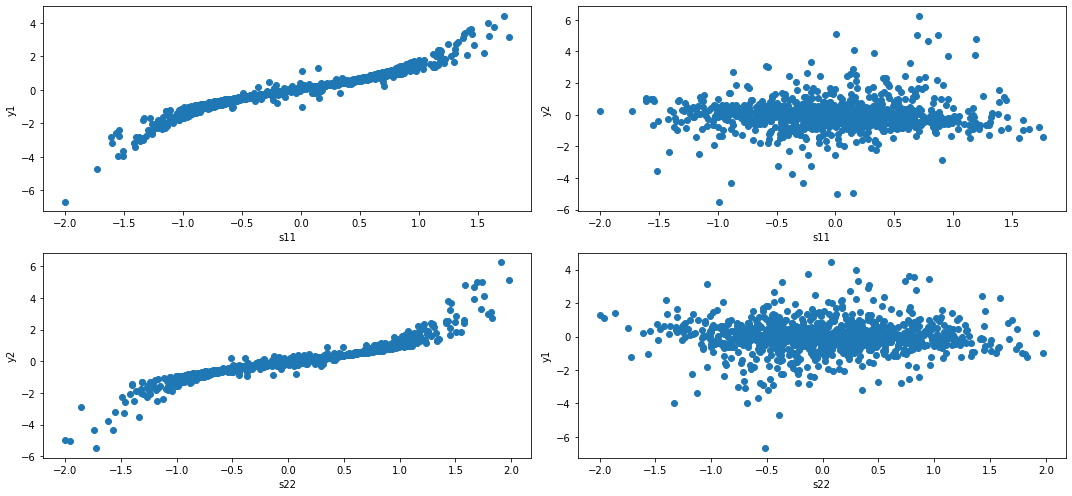

In [ ]:
W_matriz, y, X_white, J, cov = AMUSE(z,1)

#plot da recuperação dos sinais

y1 = y[0,:].reshape(-1).tolist()
y2 = y[1,:].reshape(-1).tolist()

fig,ax = plt.subplots(2,2,figsize=(15,7))

ax[0][0].scatter(s11,y1)
ax[0][0].set_xlabel('s11')
ax[0][0].set_ylabel('y1')

ax[1][0].scatter(s22,y2)
ax[1][0].set_xlabel('s22')
ax[1][0].set_ylabel('y2')

ax[1][1].scatter(s22,y1)
ax[1][1].set_xlabel('s22')
ax[1][1].set_ylabel('y1')

ax[0][1].scatter(s11,y2)
ax[0][1].set_xlabel('s11')
ax[0][1].set_ylabel('y2')

plt.tight_layout()
plt.show()

In [ ]:
# plot dependencia temporal
# s(n) s(n-1): verificar se os sinais são compativeis
# x - parecidos (carol)
# selecionar parte do gradiente (evolução)
#  gradiente *2 por causa da matriz de covariancia*2 --> /2
#

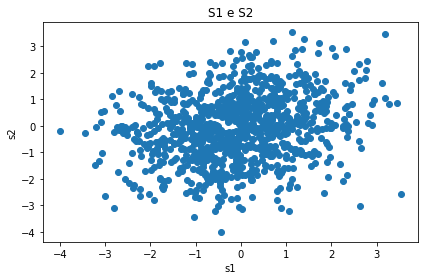

In [ ]:
plt.scatter(s1[1:],s1[:-1])
plt.xlabel('s1')
plt.ylabel('s2')
plt.title('S1 e S2')

plt.tight_layout()
plt.show()

In [ ]:
def cov_lag(x,tau):
  X_lag = x[:,:-tau] if tau != 0 else x[:,:]
  X_nolag = x[:,tau:]
  #calcula matriz de covariancia de atrasos
  cov = (1/(X_lag.shape[1]))*(np.dot(X_nolag,X_lag.T))
  #cov = np.cov(X_lag, rowvar=True, bias=True)

  return cov

In [ ]:
# Função não linear
# f=x^3, observacao do sinal x

#Nao Linear
mu = 0.05
tau = 4

for b in range(4,n_samples):

  ############### PARTE LINEAR ####################

  #Calculo das matrizes de covariancia com atrasos
  #tau=0
  #W_matriz_0, y0, X_white_0, J0, cov0 = AMUSE(z,0)
  #tau=1
  W_matriz_1, y1, X_white_1, J1, cov1 = AMUSE(z,1)
  #tau=2
  #W_matriz_2, y2, X_white_2, J2, cov2 = AMUSE(z,2)
  #tau=3
  #W_matriz_3, y3, X_white_3, J3, cov3 = AMUSE(z,3)

  #Ry = np.concatenate([
  #    np.expand_dims(cov0,axis=2),
  #    np.expand_dims(cov1,axis=2),
  #    np.expand_dims(cov2,axis=2),
  #    np.expand_dims(cov3,axis=2)], axis=2)

  #Normalização dos pesos em W
  #ey1 = Ry[0,0].reshape(2,2)
  #ey2 = Ry[1,1].reshape(2,2)

  #w1 = np.divide(W_matriz_1[0,:],ey1)
  #w2 = np.divide(W_matriz_1[1,:],ey2)

  #W = np.concatenate([w1,w2], axis = 0)

  #y1 = W*z

  Ry = (1/(y1.shape[1]))*(np.dot(y1,y1.T))
  #Ry=np.cov(y1, rowvar=True, bias=True)

  #Normalização dos pesos em W
  ey1 = Ry[0,0]
  ey2 = Ry[1,1]
  w1 = np.divide(W_matriz_1[0,:],ey1)
  w2 = np.divide(W_matriz_1[1,:],ey2)
  W = np.concatenate([w1,w2], axis = 0).reshape(2,2)

  y1 = W*X_white_1


  ################## PARTE NAO LINEAR ##################

  #tau = 0
  cov0 = cov_lag(y1,0)
  #tau = 1
  cov1 = cov_lag(y1,1)
  #tau = 2
  cov2 = cov_lag(y1,2)
  #tau = 3
  cov3 = cov_lag(y1,3)

  Ry = np.concatenate([
      np.expand_dims(cov0,axis=2),
      np.expand_dims(cov1,axis=2),
      np.expand_dims(cov2,axis=2),
      np.expand_dims(cov3,axis=2)], axis=2)

  S = np.zeros([2,2])
  grad = np.zeros([2,2])

  #SOMATORIA DOS ATRASOS
  for t in range(1,tau):
    a=t-1
    #PARA CADA MISTURA K
    for k in (0,1):
      #PARA CADA AMOSTRA
      for i in (0,1):
        for j in (0,1):
          if i != j:
            #S = 2*Ry[i,j,t]
            S[:,k]= S[:,k] + (2*Ry[i,j,t]) * (z[k,b]*W[i,k]*y1[j,(b-a)]
                                          + z[k,(b-a)]*W[j,k]*y1[i,b])

      grad = grad + S[:,:]

    C = np.array([[c1,c3],[c2, c4]])
    C = C - mu*grad
    #print((mu*grad).shape)

    c1 = C[0,0]
    c3 = C[0,1]
    c2 = 1
    c4 = 1

    C = np.array([[c1,c3],[c2, c4]])

    C[:,0]=C[:,0]/(abs(C[0,0])+abs(C[1,0]))
    C[:,1]=C[:,1]/(abs(C[0,1])+abs(C[1,1]))

    #print('C=',C)

    c1 = C[0,0]
    c3 = C[0,1]
    c2 = C[1,0]
    c4 = C[1,1]

    z11 = c1*g11
    z12 = c2*g12
    z21 = c3*g21
    z22 = c4*g22
    z1 = np.concatenate([z11,z21], axis=0)
    z2 = np.concatenate([z12,z22], axis=0)
    z = z1 + z2

    #CC[:,b]=[C[0,:].T]

    # Recuperacao de Z
    z_result = z

 #   CC(:,b)=[C(1,:)'];


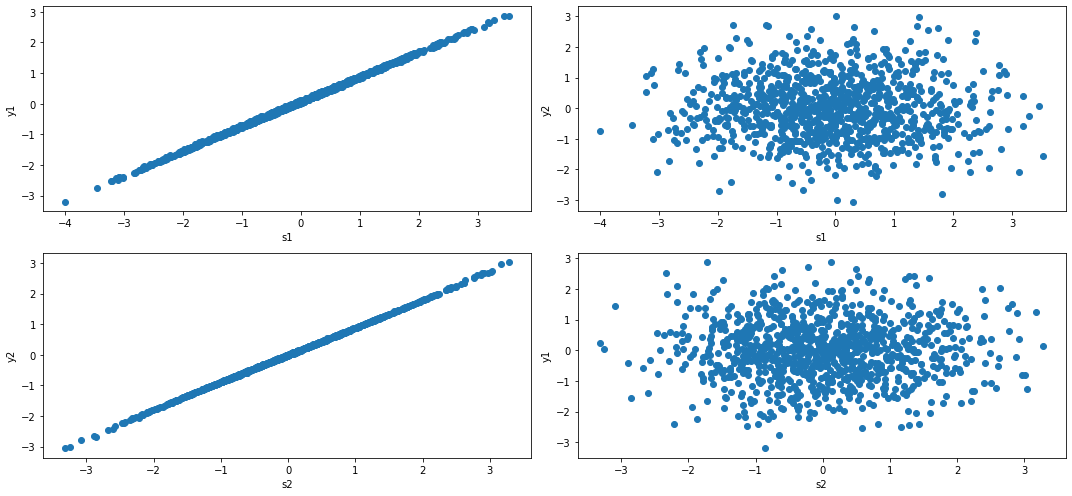

In [ ]:
#plot da recuperação dos sinais

Y1 = y1[0,:].reshape(-1).tolist()
Y2 = y1[1,:].reshape(-1).tolist()

fig,ax = plt.subplots(2,2,figsize=(15,7))

ax[0][0].scatter(s1,Y1)
ax[0][0].set_xlabel('s1')
ax[0][0].set_ylabel('y1')

ax[1][0].scatter(s2,Y2)
ax[1][0].set_xlabel('s2')
ax[1][0].set_ylabel('y2')

ax[1][1].scatter(s2,Y1)
ax[1][1].set_xlabel('s2')
ax[1][1].set_ylabel('y1')

ax[0][1].scatter(s1,Y2)
ax[0][1].set_xlabel('s1')
ax[0][1].set_ylabel('y2')

#plt.xlim(-4, 4)
#plt.ylim(-4, 4)

plt.tight_layout()
plt.show()

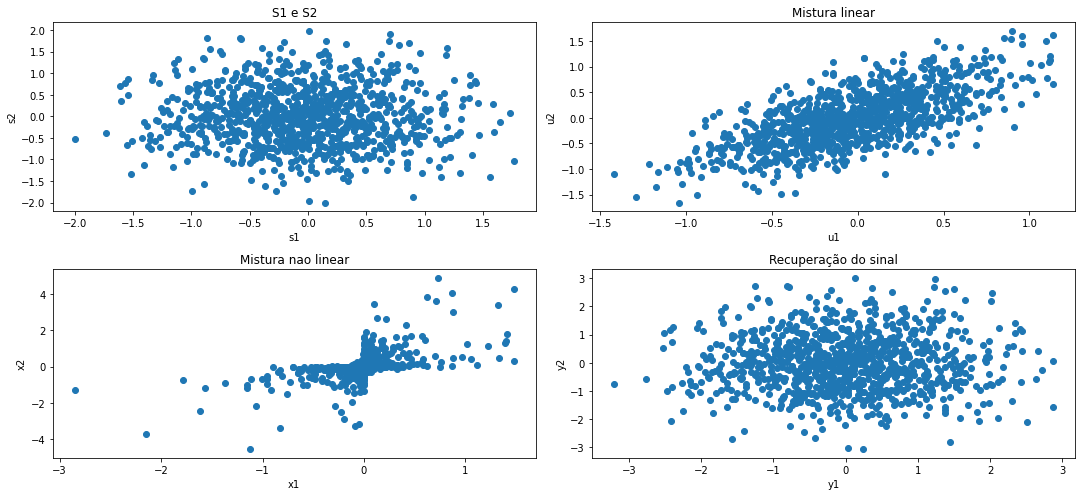

In [ ]:
#plot comparativo

y1 = z_result[0,:].reshape(-1).tolist()
y2 = z_result[1,:].reshape(-1).tolist()

fig,ax = plt.subplots(2,2,figsize=(15,7))

ax[0][0].scatter(s11,s22)
ax[0][0].set_xlabel('s1')
ax[0][0].set_ylabel('s2')
ax[0][0].set_title('S1 e S2')

ax[1][0].scatter(x[0,:].reshape(-1).tolist(),x[1,:].reshape(-1).tolist())
ax[1][0].set_xlabel('x1')
ax[1][0].set_ylabel('x2')
ax[1][0].set_title('Mistura nao linear')

ax[0][1].scatter(X[0,:].reshape(-1).tolist(),X[1,:].reshape(-1).tolist())
ax[0][1].set_xlabel('u1')
ax[0][1].set_ylabel('u2')
ax[0][1].set_title('Mistura linear')

ax[1][1].scatter(Y1,Y2)
ax[1][1].set_xlabel('y1')
ax[1][1].set_ylabel('y2')
ax[1][1].set_title('Recuperação do sinal')

#plt.xlim(-4, 4)
#plt.ylim(-4, 4)

plt.tight_layout()
plt.show()

In [ ]:
W_matriz_1, y1, X_white_1, J1, cov1 = AMUSE(z,1)
y=y1

# Calculo SIR

# Estimativa da Correlacaoo
Rsy = np.dot(S,y)/n_samples

# Valores com a maxima correlacao
#(max_Rsy,max_Rsy_idx) = max(abs(Rsy[:]))

# Order and Sign Corretion:
#if max_Rsy_idx == 1
#    y = [sign(Rsy(1,1)).*y(1,:); sign(Rsy(2,2))*y(2,:)];
#elseif max_Rsy_idx == 2
#    y = [sign(Rsy(1,2))*y(2,:); sign(Rsy(2,1)).*y(1,:)];
#elseif max_Rsy_idx == 3
#    y = [sign(Rsy(1,2))*y(2,:); sign(Rsy(2,1)).*y(1,:)];
#else
#    y = [sign(Rsy(1,1)).*y(1,:); sign(Rsy(2,2))*y(2,:)];
#end

# Media e normalizacao da Variancia
#y = y - repmat(mean(y,2) - mean(s,2),1,n);
#y = y.*repmat(sqrt(mean(s.^2,2)),1,n)./repmat(sqrt(mean(y.^2,2)),1,n);

# Medida MSE:
#mse(:,:)= mean((s - y).^2,2);

# SIR:
#sir(:,:)= 10.*log(mean(y.^2,2)./mean((s-y).^2,2));

In [ ]:
############ TO DO ##################

#1 - generalizar o numero de canais (função)
#2 - aplicar na base de eeg
#3 - aplicar na eegnet